In [1]:
%pylab inline
%run common.py

Populating the interactive namespace from numpy and matplotlib


# VXX strategy

Volatility trading has been gaining quite some attention lately and for a good reason. There is definately some money to be made there, but you need to be careful. Trading volatility often involves shorting it, which is a pretty risky business as 20% daily volatility spike is not that uncommon.

Shorting the short-term volatility etn VXX may seem like a great idea when you look at the chart from quite a distance. Due to the contango in the volatility futures, the etn experiences quite some headwind most of the time and looses a little bit its value every day. This happens due to daily rebalancing, for more information please look into the prospect.

## Strategy thesis
VXX experiences most drag when the futures curve is in a steep contango. The futures curve is approximated by the VIX-VIX3M relationship. We will short VXX when VIX3M has an unusually high premium over VIX.

## Get the data
From Yahoo Finance we need the volatility ETNs VXX and VXZ and SPY. 

In [2]:
#import libraries
import tradingWithPython as twp # general functions
import tradingWithPython.lib.cboe as cboe # cboe data
import tradingWithPython.lib.yahooFinance as yf  # yahooFinance data
import pandas as pd


In [3]:
# get data from yahoo
symbols = ['SPY','VXX','VXZ']
df_yahoo = yf.getHistoricData(symbols).xs('adj_close',axis=1,level=1)
df_yahoo


 [*********************100%***********************]  3 of 3 complete

symbol,SPY,VXX,VXZ
Date,,,
1999-12-31,104.42,NaN,NaN
2000-01-03,103.39,NaN,NaN
2000-01-04,99.35,NaN,NaN
2000-01-05,99.53,NaN,NaN
2000-01-06,97.93,NaN,NaN
...,...,...,...
2018-03-27,260.60,49.86,22.20
2018-03-28,259.83,50.91,22.70
2018-03-29,263.15,47.31,21.91


## Get data from CBOE

Cboe exchange provides [historic data](http://www.cboe.com/products/vix-index-volatility/volatility-on-stock-indexes/cboe-3-month-volatility-index-VIX3M) in csv format. We will use `urllib` to get the data and `pandas` to parse it to a `DataFrame`. I've already inspected the data to find on which line the valid data starts ( same steps as in [Reading CSV notebook](twp_202_Reading_csv_files.ipynb#Advanced-example) )

[ref]: # (getting data - get VIX data from CBOE)

In [4]:
# get data from CBOE
from urllib import request

urls = {'VIX3M':'http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vix3mdailyprices.csv',
        'VIX':'http://www.cboe.com/publish/ScheduledTask/MktData/datahouse/vixcurrent.csv'}

startLines = {'VIX':1,'VIX3M':2}

data = {}

for symbol,url in urls.items():
    print('Downloading ', symbol)
    data[symbol] = pd.read_csv(request.urlopen(url), header=startLines[symbol],index_col=0,parse_dates=True)
    print('Columns: ', data[symbol].columns)
    


Columns:  Index(['OPEN', 'HIGH', 'LOW', 'CLOSE'], dtype='object')
Columns:  Index(['VIX Open', 'VIX High', 'VIX Low', 'VIX Close'], dtype='object')


In [5]:
# get relevant columns from downloaded data

df_cboe = pd.DataFrame({'VIX':data['VIX']['VIX Close'], 
                        'VIX3M': data['VIX3M']['CLOSE']})

df_cboe = df_cboe.dropna() # remove incomplete rows
df_cboe

,VIX,VIX3M
2007-12-04,23.79,24.65
2007-12-05,22.53,23.33
2007-12-06,20.96,22.10
2007-12-07,20.85,22.18
2007-12-10,20.74,21.93
...,...,...
2018-03-27,22.50,21.94
2018-03-28,22.87,22.31
2018-03-29,19.97,20.55
2018-04-02,23.62,22.57


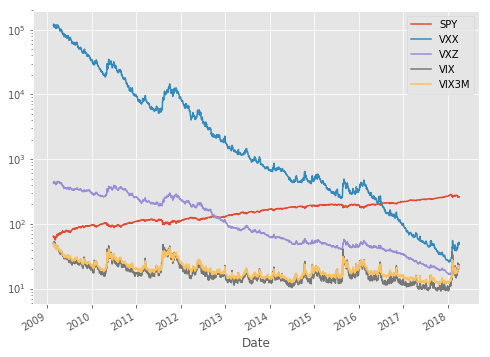

In [6]:
#combine all data to a single DataFrame

df = df_yahoo.join(df_cboe).dropna()  # add df_cboe columns and remove incomplete rows
df.plot(logy=True)

## Research relationship VIX-VIX3M
The ratio of VIX to VIX3M gives a good indication of the steepness of the fututures curve. The two are closely (co)related. Working with VIX/VIX3M ratio has been discussed in the blogsphere for some time, the best place to start is probably the [VIX an More blog](http://vixandmore.blogspot.nl/search/label/VIX%3AVIX3M).

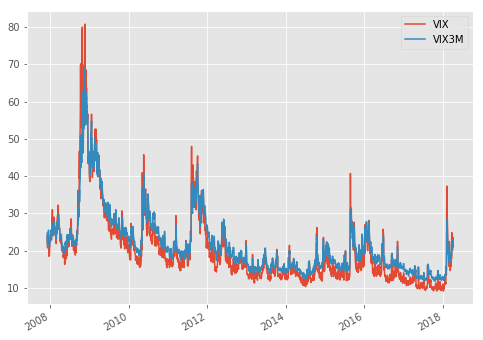

In [7]:
df_cboe.plot()

I'll assume that the relationship between VIX3M and VIX is a second order polynome, our model will be VIX3M = a*VIX^2+b*VIX+c . I aslo could have used a simple linear first-order fit. A higher order (3 or more) fit is not favorable here as it is just to sensitive to overfitting.

Poly coefficients: [-0.00341517  1.05715063  2.07459118]


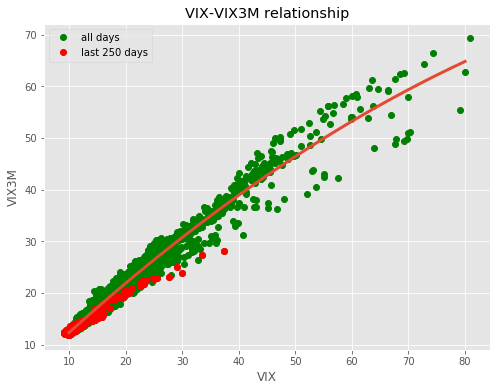

In [8]:
x = df_cboe.VIX.values # independant variable vector
y = df_cboe.VIX3M.values # dependant variable vector

order = 2 # fit order. 1-linear , 2-quadratic

p = np.polyfit(x,y,order)
print('Poly coefficients:' ,  p)

xx = np.linspace(10,80) # linear vector for evaluating fit


plot(x,y,'go')

w = 250
plot(x[-w:],y[-w:],'ro') # plot last w days in red
plot(xx,np.polyval(p,xx),linewidth=3) # plot computed fit

grid(True)

legend(('all days','last %i days' % w))
title('VIX-VIX3M relationship')

xlabel('VIX')
ylabel('VIX3M')


now we can create a function that estimates VIX3M based on VIX value. The difference between the current VIX3M and its estimated value will be our indicator *delta*

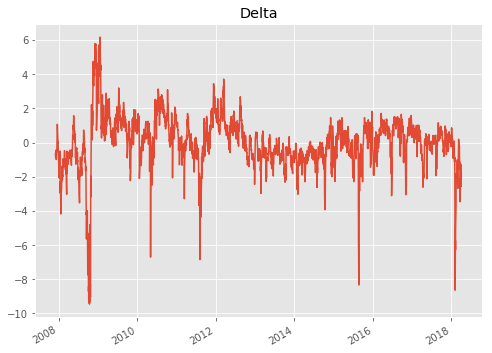

In [9]:

def estimateVIX3M(vix, p):
    ''' estimate VIX3M based on VIX value '''
    VIX3M = pd.Series(index=vix.index,data=np.polyval(p, vix))
    return VIX3M


delta = (df_cboe.VIX3M-estimateVIX3M(df_cboe.VIX,p)).dropna() # create delta indicator
delta.plot()
title('Delta')

Let's simulate a couple of strategies. Individual results are saved to (temporary) *pnl* Series. The results of all strategies will be saved to the *PNL* DataFrame (capital letters)

In [10]:
PNL = pd.DataFrame(index=delta.index) # init PNL with same dates as delta

----Sharpe ratio----
dumbVXX         1.04
SPY             1.04
smartVXX        1.74
smartSPY_VXX    1.58
dtype: float64
----Profit ratio----
dumbVXX         12.52
SPY             11.12
smartVXX        19.21
smartSPY_VXX    17.36
dtype: float64


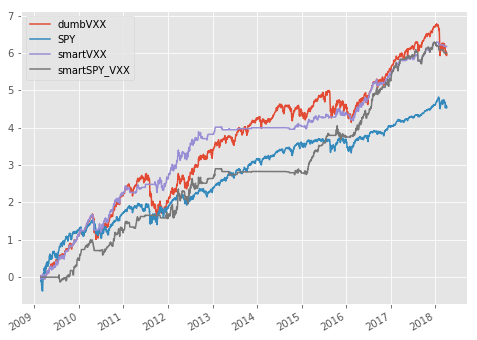

In [11]:

#-------dumbVXX strategy---------------
# just sell VXX and rebalance each day to keep capital constant
ret = df.VXX.pct_change()
pnl = -ret # maintain short position
PNL['dumbVXX'] = pnl


#--------SPY buy&hold----------------
ret = df.SPY.pct_change()
pnl = ret*3 # multiplying by 3 here because VXX has beta of about 3. .
PNL['SPY'] = pnl


#--------smartVXX strategy------------
# hold short VXX position when delta is positive (VIX3M is higher than it should be compared to VIX, the futures are in stronger than 
# normal contango.

threshDelta = 0 # delta threshold, strategy parameter
tradeDir = 1*(delta > threshDelta) # trading direction. Multiply by 1 to convert [True/False] to numeric values [1/0]
tradeDir = -tradeDir.fillna(0) # fill nans with zeros, '-' is for the short position

ret = df.VXX.pct_change() # daily returns
pnl = ret * tradeDir.shift(1) # don't forget to shift(1), todays position has effect on tomorrows return.

PNL['smartVXX'] = pnl


#-------smartSPY_VXX pair-----------
# a near market-neutral pair would be a combination of 3xSPY+1xVXX. Let's trade it with same signals
threshDelta = 0 # delta threshold, strategy parameter
ret = df.VXX.pct_change()+3*df.SPY.pct_change()
ret = ret*2 # increase leverage to achieve same beta as VXX
tradeDir = 1*((delta > threshDelta) & (df.VIX.reindex(delta.index) < 25))# trading direction. Multiply by 1 to convert [True/False] to numeric values [1/0]
tradeDir = -tradeDir.fillna(0) # fill nans with zeros, '-' is for the short position
pnl = ret * tradeDir.shift(1) # don't forget to shift(1), todays position has effect on tomorrows return.
PNL['smartSPY_VXX'] = pnl

#------------------------------------
PNL = PNL.dropna() # remove rows with mising entries. 

PNL.cumsum().plot() 

#---------print statistics
print('----Sharpe ratio----')
print(twp.sharpe(PNL))
print('----Profit ratio----')
print(twp.profitRatio(PNL))


It is clear that the strategies using delta are performing much better than VXX and SPY buy-and-hold in terms of return/drawdown. A lower drawdown will enable to increase leverage or simply reduce the stress of watching a portfolio go down.

## More precise simulation


Above simulations are just a quick exploration of the possible strategies. I will now calculate the `smartVXX` strategy in more detail. We'll be using a walk-forward again.

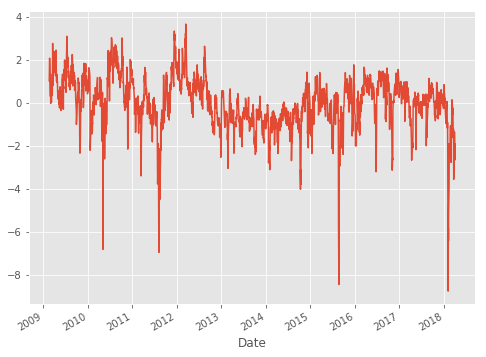

In [12]:
# create estimator class for  VIX3M as a function of VIX. Same functionality as before,
# but now nicely wrapped inside a class

class VIX3M_estimator(object):
    ''' class for estimating VIX3M based on VIX value '''
    def __init__(self,order=2):
        ''' order: polynome order of the model '''
        self.order = order
        
        self.p = None
        
    def fit(self,vix,VIX3M):
        ''' compute model based on vix and VIX3M values '''
        vol = pd.DataFrame({'vix':vix,'VIX3M':VIX3M}).dropna() # create dataframe, drop missing rows
               
        x = vix.values # independant variable vector
        y = VIX3M.values # dependant variable vector
        
        self.p = np.polyfit(x,y,self.order)
       
        
    def estimate(self,vix):
        ''' estimate VIX3M based on model '''
        VIX3M = pd.Series(index=vix.index,data=np.polyval(self.p, vix))
        return VIX3M
    
#----test estimator class
    
e = VIX3M_estimator(order=2)
e.fit(df.VIX,df.VIX3M)

delta = (df.VIX3M-e.estimate(df.VIX)).dropna() # create delta indicator
delta.plot()

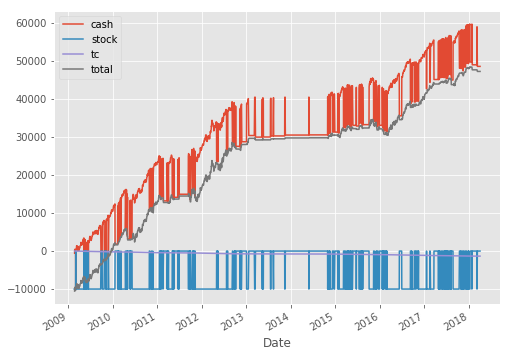

In [13]:
# pos2pnl is same as in twp toolbox, only simplified to work with Series.
def pos2pnl(price,position , ibTransactionCost=False ):
    """
    calculate pnl based on price and position
    Inputs:
    ---------
    price: series  of price
    position: number of shares at each time. Column names must be same as in price
    ibTransactionCost: use bundled Interactive Brokers transaction cost of 0.005$/share

    Returns a portfolio DataFrame. 
    Output is *cumulative* pnl
    """

    delta=position.diff()
    port = pd.DataFrame(index=price.index)

    
    port['cash'] = (-delta*price).cumsum()
    port['stock'] = (position*price)

    if ibTransactionCost:
        tc = -0.005*position.diff().abs() # basic transaction cost
        tc[(tc>-1) & (tc<0)] = -1  # everything under 1$ will be ceil'd to 1$
        port['tc'] = tc.cumsum()
    else:
        port['tc'] = 0.

    port['total'] = port['stock']+port['cash']+port['tc']

    return port



def simulate(vxx,delta, threshDelta = 0, bet=10000):
    ''' simulate smartVXX strategy '''
    
    tradeDir = 1*(delta > threshDelta) # trading direction. 
    
    
    tradeDir = -tradeDir.fillna(0) # fill nans with zeros, '-' is for the short position
    pos = tradeDir*bet/vxx # number of shares held
    
    
    pnl = pos2pnl(vxx,pos, ibTransactionCost=True)
    return pnl

#---test function

pnl = simulate(df.VXX, delta)

pnl.plot()


In [14]:
def generateFWD(data,nTrain = 250, nTest=50):
    ''' 
    Walk forward generator. 
    '''
    nTotal = nTrain+nTest
    
    for tp in range(nTrain,len(data) - nTest, nTest) :  # xrange() is a little more efficient than range()
        # tp is a 'testpoint' which is at in-sample/out-of-sample boundary
        yield (data.iloc[tp-nTrain:tp,:], data.iloc[tp:tp+nTest]) # return test and train datasets

        
# create datasets. Each element contains a [train,test] pair
# train is in-sample data, test is out-of-sample data
datasets = [[train,test] for train,test in generateFWD(df)]

print('Created %i datasets' % len(datasets))

Created 40 datasets


Sharpe: 1.15062029972
Profit ratio: 11.1532132193


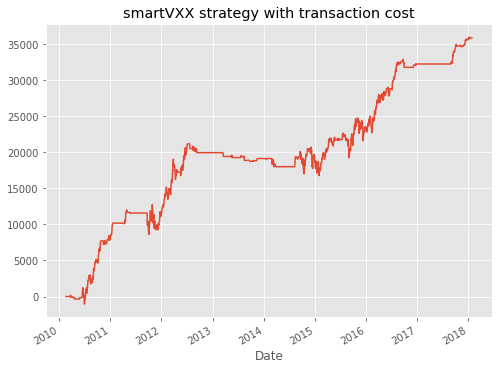

In [15]:
# perform walk-forward test
pnl = []

est = VIX3M_estimator(order=2)

for dataset in datasets:
    train = dataset[0]
    test = dataset[1]
    
    est.fit(train.VIX,train.VIX3M)
    delta = (test.VIX3M-est.estimate(test.VIX)).dropna() # create delta indicator
    
    pnl.append(simulate(test.VXX,delta, threshDelta = 0)['total'].diff()) 
    # .diff() is needed because pos2pnl returns cumulative result.
    
pnl = pd.concat(pnl).fillna(0) # convert list of dataframes to one dataframe
pnl.cumsum().plot()
title('smartVXX strategy with transaction cost')

print('Sharpe:', twp.sharpe(pnl))
print('Profit ratio:', twp.profitRatio(pnl))

With a more precise backtest the strategy loses some sharpe and there are more inactive periods. The profit ratio is still not bad. This could be improved by introducing optimization for each training period. 